# Chapter 3

In [1]:
import sympy as sp
from sympy import symbols, sqrt, init_printing
from sympy_equation import Eqn, solve, table_of_expressions
from ambiance import Atmosphere
import numpy as np
import pint
import pygasflow
from pygasflow import *
from pygasflow.atd import *
init_printing()
pygasflow.defaults.solver_to_dict = True

ureg = pint.UnitRegistry()
# use "~P" to format units with unicode
ureg.formatter.default_format = "~"
pygasflow.defaults.pint_ureg = ureg
K = ureg.K
m = ureg.m
km = ureg.km
s = ureg.s
J = ureg.J
W = ureg.W
kg = ureg.kg
deg = ureg.deg

## P 3.1

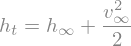

In [2]:
ht, hinf, vinf, Minf = symbols(r"h_t, h_\infty, v_\infty, M_\infty")
h = Eqn(ht, hinf + vinf**2 / 2)
h

In [3]:
cv, cp, gamma, R, Tt, Tinf, ainf = symbols(r"c_v, c_p, gamma, R, T_t, T_\infty, a_\infty")
e1 = Eqn(gamma, cp / cv)
e2 = Eqn(cv, R / (gamma - 1))

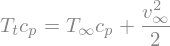

In [4]:
h = h.subs({ht: cp * Tt, hinf: cp * Tinf})
h

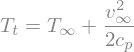

In [5]:
h = (h / cp).expand()
h

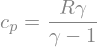

In [6]:
e3 = solve(e1.subs(e2), cp)[0]
e3

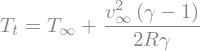

In [7]:
h = h.subs(e3)
h

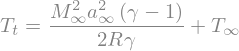

In [8]:
h = h.subs(vinf, Minf * ainf)
h

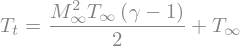

In [9]:
h = h.subs(ainf, sqrt(gamma * R * Tinf))
h

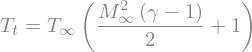

In [10]:
h = h.collect(Tinf)
h

## P 3.2

In [11]:
alpha = 0 * deg
vinf = 1 * km / s
H = 30 * km
gamma = 1.4
R = 287.05 * J / (kg * K)

In [12]:
atmosphere = Atmosphere(H.to("m").magnitude)
Tinf = atmosphere.temperature[0] * K
Tinf

<Quantity(226.509084, 'kelvin')>

In [13]:
ainf = sound_speed(gamma, R, Tinf).to("km / s")
ainf

<Quantity(0.301707152, 'kilometer / second')>

In [14]:
Minf = vinf / ainf
Minf

<Quantity(3.31447231, 'dimensionless')>

In [15]:
flow = isentropic_solver("m", Minf)
flow.show()

key     quantity            
----------------------------
m       M                        3.31447231
pr      P / P0                   0.01711322
dr      rho / rho0               0.05471344
tr      T / T0                   0.31277902
prs     P / P*                   0.03239411
drs     rho / rho*               0.08630723
trs     T / T*                   0.37533483
urs     U / U*                   2.03059741
ars     A / A*                   5.70596370
ma      Mach Angle [deg]        17.56016750
pm      Prandtl-Meyer [deg]     55.46993616


In [16]:
T_Tt = flow["tr"]
Tt = (1 / T_Tt) * Tinf
Tt

<Quantity(724.182461, 'kelvin')>

Compute the recovery factors:

In [17]:
Pr = Prandtl(gamma)
r_lam = recovery_factor(Pr, laminar=True)
r_tur = recovery_factor(Pr, laminar=False)
print("Recovery factor for laminar boundary layer:", r_lam)
print("Recovery factor for turbulent boundary layer:", r_tur)

Recovery factor for laminar boundary layer: 0.8583950752789521
Recovery factor for turbulent boundary layer: 0.9032157004286028


Compute the recovery temperatures:

In [18]:
Tr_lam = recovery_temperature(Tinf, Minf, r_lam)
Tr_lam

<Quantity(653.709459, 'kelvin')>

In [19]:
Tr_tur = recovery_temperature(Tinf, Minf, r_tur)
Tr_tur

<Quantity(676.015491, 'kelvin')>

## P 3.3

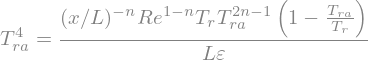

In [20]:
Tra, Tr, eps, Re, L, n, C, x_L = symbols(r"T_ra, T_r, \varepsilon, Re, L, n, C, (x/L)", positive=True)
e0 = Eqn(
    Tra**4, 
    Tra**(2 * n - 1) / eps * Re**(1 - n) / x_L**n / L * Tr * (1 - Tra / Tr)
)
e0

Assuming $T_{ra} << T_{r}$:

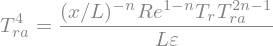

In [21]:
e = e0.subs(Tra / Tr, 0)
e

Bringing $T_{ra}^{2 n - 1}$ to the LHS:

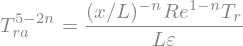

In [22]:
e = (e / Tra**(2 * n - 1)).apply(sp.powsimp)
e

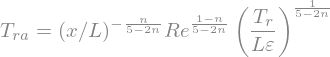

In [23]:
e = e.apply(lambda t: sp.root(t, 5-2*n).expand().powsimp())
e

In [24]:
toe = table_of_expressions(e.rhs)

| idx | args |
|:-----:|:------|
| 0 | $(x/L)^{- \frac{n}{5 - 2 n}}$ |
| 1 | $Re^{\frac{1 - n}{5 - 2 n}}$ |
| 2 | $\left(\frac{T_{r}}{L \varepsilon}\right)^{\frac{1}{5 - 2 n}}$ |


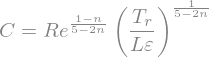

In [25]:
C = sp.symbols("C")
c = Eqn(C, sp.Mul(*toe[1:]))
c

In [26]:
e = e.subs(c.swap)
e

Let's solve for $C$:

In [27]:
C_eq = solve(e, C)[0]
C_eq

And create the numerical functions so that they can be evaluated with `pint` quantities:

In [28]:
C_func = sp.lambdify([x_L, Tra, n], C_eq.rhs)
T_func = sp.lambdify([x_L, C, n], e.rhs)

For the laminar case, $n=0.5$:

In [29]:
n_lam = 0.5
x_L1 = 0.1
Tw1 = 1100 * K # from Fig. 3.3
C_val = C_func(x_L1, Tw1, n_lam)
C_val

<Quantity(824.88363, 'kelvin')>

In [30]:
x_L2 = 0.75
Tw2 = 880 * K # from Fig. 3.3
Tw2_comp = T_func(x_L2, C_val, n_lam)
Tw2, Tw2_comp

(<Quantity(880, 'kelvin')>, <Quantity(855.086455, 'kelvin')>)

In [31]:
Tw2 - Tw2_comp

<Quantity(24.9135446, 'kelvin')>

It clearly underestimates the result, but not by much. Maybe it has something to do with the assumption that $T_{ra} << T_{r}$.

## P 3.4

In [32]:
Tw1 = 656 * K
C_val = C_func(x_L1, Tw1, n_lam)
C_val

<Quantity(491.930601, 'kelvin')>

In [33]:
Tw2 = 522 * K
Tw2_comp = T_func(x_L2, C_val, n_lam)
Tw2_comp

<Quantity(509.942468, 'kelvin')>

In [34]:
Tw2 - Tw2_comp

<Quantity(12.0575321, 'kelvin')>

## P 3.5

In [35]:
n_tur = 0.2

In [36]:
Tw1 = 874 * K
C_val = C_func(x_L1, Tw1, n_tur)
C_val

<Quantity(790.739023, 'kelvin')>

In [37]:
Tw2 = 820 * K
Tw2_comp = T_func(x_L2, C_val, n_tur)
Tw2_comp

<Quantity(800.691634, 'kelvin')>

In [38]:
Tw2 - Tw2_comp

<Quantity(19.3083661, 'kelvin')>

## P 3.6

In [39]:
n_tur = 0.1

In [40]:
Tw1 = 874 * K
C_val = C_func(x_L1, Tw1, n_tur)
C_val

<Quantity(833.063486, 'kelvin')>

In [41]:
Tw2 = 820 * K
Tw2_comp = T_func(x_L2, C_val, n_tur)
Tw2_comp

<Quantity(838.071341, 'kelvin')>

In [42]:
Tw2 - Tw2_comp

<Quantity(-18.0713411, 'kelvin')>

## P 3.7

In [43]:
H = 60.65 * km
Minf = 17
x_L = 0.5
gamma = 1.3

In [44]:
atmosphere = Atmosphere(H.to("m").magnitude)
Tinf = atmosphere.temperature[0] * K
Tinf

<Quantity(245.234942, 'kelvin')>

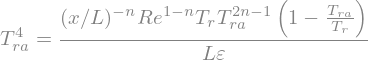

In [45]:
e0

Assuming $T_{ra} << T_{r}$:

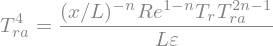

In [46]:
e = e0.subs(Tra / Tr, 0)
e

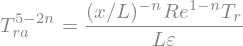

In [47]:
e = (e / Tra**(2*n - 1)).apply(sp.powsimp)
e

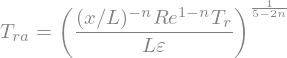

In [48]:
e = e.apply(sp.root, e.lhs.exp)
e

In [49]:
e = e.expand()
e

In [50]:
toe = table_of_expressions(e.rhs)

| idx | args |
|:-----:|:------|
| 0 | $(x/L)^{- \frac{n}{5 - 2 n}}$ |
| 1 | $L^{- \frac{1}{5 - 2 n}}$ |
| 2 | $Re^{- \frac{n}{5 - 2 n} + \frac{1}{5 - 2 n}}$ |
| 3 | $T_{r}^{\frac{1}{5 - 2 n}}$ |
| 4 | $\varepsilon^{- \frac{1}{5 - 2 n}}$ |


In [51]:
c_eq = Eqn(C, e.rhs / toe[3])
c_eq

In [52]:
e = e.subs(c_eq.swap)
e

Assume:

* $Pr = 1$: typical order of magnitude for gases
* $\gamma = 1.3$: take into account for chemical reacting gases.

In [53]:
Pr = 1
gamma = 1.3
r_lam = recovery_factor(Pr, laminar=True)
r_lam

In [54]:
Tr_lam_1 = recovery_temperature(Tinf, Minf, r_lam, gamma)
Tr_lam_2 = recovery_temperature(Tinf, 15.7, r_lam, gamma)
Tr_lam_1, Tr_lam_2

(<Quantity(10876.1697, 'kelvin')>, <Quantity(9312.42909, 'kelvin')>)

Let's compute the ratio $T_{ra, 1} / T_{ra, 2}$:

$$
\frac{T_{ra, 1}}{T_{ra, 2}} = \frac{C T_{r, 1}^{\frac{1}{5 - 2 n}}}{C T_{r, 2}^{\frac{1}{5 - 2 n}}} = \frac{T_{r, 1}^{\frac{1}{5 - 2 n}}}{T_{r, 2}^{\frac{1}{5 - 2 n}}}
$$

In [55]:
Tr_expr = e.rhs / C
Tr_expr

In [56]:
Tr_func = sp.lambdify([Tr, n], Tr_expr)
n_lam = 0.5
Tra1_M17 = Tr_func(Tr_lam_1, n_lam)
Tra2_M15_7 = Tr_func(Tr_lam_2, n_lam)
Tra1_M17, Tra2_M15_7

(<Quantity(10.2121925, 'kelvin ** 0.25')>,
 <Quantity(9.82348858, 'kelvin ** 0.25')>)

In [57]:
ratio = Tra1_M17 / Tra2_M15_7
ratio

<Quantity(1.03956883, 'dimensionless')>

From Figure 3.3, at $M_{\infty} = 15.7$ and $x/L = 0.5$:

In [58]:
Tw_M15_7 = 916 * K

Then, for $M_{\infty} = 17$ at $x / L = 0.5$:

In [59]:
Tw_M17 = ratio * Tw_M15_7
Tw_M17

<Quantity(952.245048, 'kelvin')>

## P 3.8

In [60]:
Tr_lam_1 = recovery_temperature(Tinf, 14, r_lam, gamma)
Tr_lam_2 = recovery_temperature(Tinf, 15.7, r_lam, gamma)
Tr_lam_1, Tr_lam_2

(<Quantity(7455.14225, 'kelvin')>, <Quantity(9312.42909, 'kelvin')>)

In [61]:
Tra1_M14 = Tr_func(Tr_lam_1, n_lam)
Tra2_M15_7 = Tr_func(Tr_lam_2, n_lam)
Tra1_M14, Tra2_M15_7

(<Quantity(9.29210232, 'kelvin ** 0.25')>,
 <Quantity(9.82348858, 'kelvin ** 0.25')>)

In [62]:
ratio = Tra1_M14 / Tra2_M15_7
ratio

<Quantity(0.945906563, 'dimensionless')>

In [63]:
Tw_M15_7 = 916 * K
Tw_M14 = ratio * Tw_M15_7
Tw_M14

<Quantity(866.450412, 'kelvin')>